In [2]:
# 라이브러리
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import EarlyStopping
import numpy as np
import pandas as pd

In [3]:
df = pd.read_csv("C:\\multi_final\\data\\2022년.csv", encoding='cp949')
df

,일시,대여소번호,대여소명,시간대,거치대수량,addr1,addr2,기온,강수형태,강수량,총생활인구수
0,2022-01-01,1124,1124. 발산역 6번 출구 뒤,0,3,우장산동,강서구,-4.4,0.0,0.0,32248.4049
1,2022-01-01,1124,1124. 발산역 6번 출구 뒤,1,4,우장산동,강서구,-2.5,0.0,0.0,30433.3054
2,2022-01-01,1124,1124. 발산역 6번 출구 뒤,2,3,우장산동,강서구,-1.6,0.0,0.0,30371.5035
3,2022-01-01,1124,1124. 발산역 6번 출구 뒤,3,3,우장산동,강서구,0.2,0.0,0.0,30196.7935
4,2022-01-01,1124,1124. 발산역 6번 출구 뒤,4,3,우장산동,강서구,0.6,0.0,0.0,29734.8866
...,...,...,...,...,...,...,...,...,...,...,...
78685,2022-12-31,3798,3798. 그랜드아이파크아파트 앞,19,16,화곡6동,강서구,0.8,0.0,0.0,20310.9087
78686,2022-12-31,3798,3798. 그랜드아이파크아파트 앞,20,14,화곡6동,강서구,-0.2,0.0,0.0,20972.5718
78687,2022-12-31,3798,3798. 그랜드아이파크아파트 앞,21,16,화곡6동,강서구,-0.5,0.0,0.0,21133.8094
78688,2022-12-31,3798,3798. 그랜드아이파크아파트 앞,22,15,화곡6동,강서구,-0.6,0.0,0.0,21321.0298


In [4]:
# 대여소 번호별 총 거치대 수를 사전으로 정의
total_docks = {
    1124: 6,
    1153: 17,
    1158: 20,
    1160: 20,
    1166: 10,
    2701: 26,
    2715: 25,
    2721: 12,
    2728: 55,
    3798: 11
}

In [5]:
# 거치대 수량을 해당 대여소의 총 거치대 수로 나누는 함수 정의
def calculate_dock_ratio(row):
    station_id = row['대여소번호']
    if station_id in total_docks:
        total_dock = total_docks[station_id]
        return row['거치대수량'] / total_dock
    else:
        return None  # 대여소 번호가 사전에 없는 경우 None 반환


In [6]:
# '거치대비율' 열에 계산 결과 적용
df['거치대비율'] = df.apply(calculate_dock_ratio, axis=1)

In [7]:
# '일시'와 '시간대'를 결합하여 'datetime' 열 생성
df['datetime'] = pd.to_datetime(df['일시']) + pd.to_timedelta(df['시간대'], unit='h')

In [8]:
# '대여소번호'를 'ID'로, '거치대수량'을 'count'로 이름 변경
df.rename(columns={'대여소번호': 'ID', '거치대수량': 'count', '일시' : 'date', '시간대' : 'hour', '거치대비율':'ratio'}, inplace=True)

In [9]:
# 필요한 열만 선택
df = df[['ID', 'date', 'hour', 'count', 'datetime', 'ratio']]
df

,ID,date,hour,count,datetime,ratio
0,1124,2022-01-01,0,3,2022-01-01 00:00:00,0.500000
1,1124,2022-01-01,1,4,2022-01-01 01:00:00,0.666667
2,1124,2022-01-01,2,3,2022-01-01 02:00:00,0.500000
3,1124,2022-01-01,3,3,2022-01-01 03:00:00,0.500000
4,1124,2022-01-01,4,3,2022-01-01 04:00:00,0.500000
...,...,...,...,...,...,...
78685,3798,2022-12-31,19,16,2022-12-31 19:00:00,1.454545
78686,3798,2022-12-31,20,14,2022-12-31 20:00:00,1.272727
78687,3798,2022-12-31,21,16,2022-12-31 21:00:00,1.454545
78688,3798,2022-12-31,22,15,2022-12-31 22:00:00,1.363636


In [10]:
# 대여소 번호(ID)별로 그룹화
grouped = df.groupby('ID')

In [11]:
# 시퀀스 데이터로 변환하는 함수
def create_dataset(X, y, look_back=1):
    Xs, ys = [], []
    for i in range(len(X) - look_back):
        v = X.iloc[i:(i + look_back)].values
        Xs.append(v)
        ys.append(y.iloc[i + look_back])
    return np.array(Xs), np.array(ys)

look_back = 3  # 과거 3개의 시간 단계를 사용하여 다음 단계를 예측

In [14]:
from sklearn.preprocessing import MinMaxScaler

# 정규화를 위한 스케일러 초기화
scaler = MinMaxScaler()

df['ratio_scaled'] = scaler.fit_transform(df['ratio'].values.reshape(-1,1))
# 결과 확인
print(df.head())

     ID        date  hour  count            datetime     ratio  ratio_scaled
0  1124  2022-01-01     0      3 2022-01-01 00:00:00  0.500000      0.034884
1  1124  2022-01-01     1      4 2022-01-01 01:00:00  0.666667      0.046512
2  1124  2022-01-01     2      3 2022-01-01 02:00:00  0.500000      0.034884
3  1124  2022-01-01     3      3 2022-01-01 03:00:00  0.500000      0.034884
4  1124  2022-01-01     4      3 2022-01-01 04:00:00  0.500000      0.034884


C:\Users\hyeon\AppData\Local\Temp\ipykernel_6668\2108619879.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ratio_scaled'] = scaler.fit_transform(df['ratio'].values.reshape(-1,1))


In [15]:
# 각 그룹(대여소) 별로 모델 학습을 위한 딕셔너리
history_dict = {}

for ID, group in grouped:
    # 현재 그룹(대여소)의 데이터
    stop_data = group
    
    # 입력 변수와 예측할 변수
    X = stop_data[['hour', 'ratio_scaled']]  # ratio_scaled 대신 ratio 사용 (예시 변경 가능)
    y = stop_data['ratio_scaled']  # ratio_scaled 대신 ratio 사용 (예시 변경 가능)
    
    # 시퀀스 데이터 생성 (create_dataset 함수는 정의되어 있어야 함)
    X_seq, y_seq = create_dataset(X, y, look_back)
    
    # 학습 및 테스트 데이터 분할
    X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)
    
    # LSTM 모델 구성
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(look_back, X_train.shape[2])))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    
    # 모델 학습
    history = model.fit(X_train, y_train, epochs=10, batch_size=1, verbose=2, validation_split=0.2)
    
    # 학습 과정 저장
    history_dict[ID] = history

Epoch 1/10


c:\Users\hyeon\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5033/5033 - 10s - 2ms/step - loss: 0.0060 - val_loss: 0.0055
Epoch 2/10
5033/5033 - 11s - 2ms/step - loss: 0.0033 - val_loss: 0.0028
Epoch 3/10
5033/5033 - 21s - 4ms/step - loss: 0.0030 - val_loss: 0.0028
Epoch 4/10
5033/5033 - 10s - 2ms/step - loss: 0.0030 - val_loss: 0.0025
Epoch 5/10
5033/5033 - 10s - 2ms/step - loss: 0.0028 - val_loss: 0.0026
Epoch 6/10
5033/5033 - 10s - 2ms/step - loss: 0.0028 - val_loss: 0.0034
Epoch 7/10
5033/5033 - 8s - 2ms/step - loss: 0.0028 - val_loss: 0.0028
Epoch 8/10
5033/5033 - 10s - 2ms/step - loss: 0.0028 - val_loss: 0.0024
Epoch 9/10
5033/5033 - 16s - 3ms/step - loss: 0.0027 - val_loss: 0.0028
Epoch 10/10
5033/5033 - 15s - 3ms/step - loss: 0.0028 - val_loss: 0.0028
Epoch 1/10


c:\Users\hyeon\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5033/5033 - 19s - 4ms/step - loss: 0.0033 - val_loss: 0.0023
Epoch 2/10
5033/5033 - 14s - 3ms/step - loss: 0.0016 - val_loss: 8.6688e-04
Epoch 3/10
5033/5033 - 15s - 3ms/step - loss: 0.0011 - val_loss: 0.0022
Epoch 4/10
5033/5033 - 14s - 3ms/step - loss: 9.4448e-04 - val_loss: 8.4112e-04
Epoch 5/10
5033/5033 - 11s - 2ms/step - loss: 9.1292e-04 - val_loss: 8.1205e-04
Epoch 6/10
5033/5033 - 10s - 2ms/step - loss: 8.9633e-04 - val_loss: 8.4247e-04
Epoch 7/10
5033/5033 - 10s - 2ms/step - loss: 8.6956e-04 - val_loss: 9.2486e-04
Epoch 8/10
5033/5033 - 11s - 2ms/step - loss: 8.6182e-04 - val_loss: 0.0016
Epoch 9/10
5033/5033 - 11s - 2ms/step - loss: 8.4522e-04 - val_loss: 7.7025e-04
Epoch 10/10
5033/5033 - 9s - 2ms/step - loss: 8.3315e-04 - val_loss: 8.5687e-04
Epoch 1/10


c:\Users\hyeon\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5033/5033 - 22s - 4ms/step - loss: 0.0079 - val_loss: 0.0016
Epoch 2/10
5033/5033 - 13s - 3ms/step - loss: 0.0010 - val_loss: 0.0013
Epoch 3/10
5033/5033 - 12s - 2ms/step - loss: 7.3251e-04 - val_loss: 8.7261e-04
Epoch 4/10
5033/5033 - 8s - 2ms/step - loss: 5.7242e-04 - val_loss: 3.9400e-04
Epoch 5/10
5033/5033 - 14s - 3ms/step - loss: 4.9092e-04 - val_loss: 4.3298e-04
Epoch 6/10
5033/5033 - 13s - 3ms/step - loss: 4.5779e-04 - val_loss: 3.9944e-04
Epoch 7/10
5033/5033 - 11s - 2ms/step - loss: 4.4301e-04 - val_loss: 7.4889e-04
Epoch 8/10
5033/5033 - 9s - 2ms/step - loss: 4.3054e-04 - val_loss: 5.5958e-04
Epoch 9/10
5033/5033 - 10s - 2ms/step - loss: 4.0710e-04 - val_loss: 3.9276e-04
Epoch 10/10
5033/5033 - 10s - 2ms/step - loss: 4.0488e-04 - val_loss: 4.0158e-04
Epoch 1/10


c:\Users\hyeon\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5033/5033 - 13s - 3ms/step - loss: 0.0013 - val_loss: 4.9585e-04
Epoch 2/10
5033/5033 - 11s - 2ms/step - loss: 5.0104e-04 - val_loss: 3.1052e-04
Epoch 3/10
5033/5033 - 10s - 2ms/step - loss: 3.6717e-04 - val_loss: 2.5635e-04
Epoch 4/10
5033/5033 - 10s - 2ms/step - loss: 3.0572e-04 - val_loss: 2.3065e-04
Epoch 5/10
5033/5033 - 10s - 2ms/step - loss: 2.7951e-04 - val_loss: 3.0844e-04
Epoch 6/10
5033/5033 - 14s - 3ms/step - loss: 2.6222e-04 - val_loss: 2.0329e-04
Epoch 7/10
5033/5033 - 12s - 2ms/step - loss: 2.5833e-04 - val_loss: 4.9549e-04
Epoch 8/10
5033/5033 - 7s - 1ms/step - loss: 2.4272e-04 - val_loss: 3.3601e-04
Epoch 9/10
5033/5033 - 8s - 2ms/step - loss: 2.5213e-04 - val_loss: 2.2442e-04
Epoch 10/10
5033/5033 - 10s - 2ms/step - loss: 2.3937e-04 - val_loss: 3.0630e-04
Epoch 1/10


c:\Users\hyeon\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5033/5033 - 17s - 3ms/step - loss: 0.0054 - val_loss: 0.0013
Epoch 2/10
5033/5033 - 22s - 4ms/step - loss: 0.0017 - val_loss: 0.0011
Epoch 3/10
5033/5033 - 15s - 3ms/step - loss: 0.0012 - val_loss: 8.6990e-04
Epoch 4/10
5033/5033 - 25s - 5ms/step - loss: 0.0010 - val_loss: 8.1912e-04
Epoch 5/10
5033/5033 - 18s - 3ms/step - loss: 9.6826e-04 - val_loss: 7.1678e-04
Epoch 6/10
5033/5033 - 22s - 4ms/step - loss: 8.8973e-04 - val_loss: 7.1235e-04
Epoch 7/10
5033/5033 - 10s - 2ms/step - loss: 8.5226e-04 - val_loss: 9.1170e-04
Epoch 8/10
5033/5033 - 11s - 2ms/step - loss: 8.4449e-04 - val_loss: 7.0776e-04
Epoch 9/10
5033/5033 - 8s - 2ms/step - loss: 8.2717e-04 - val_loss: 7.3548e-04
Epoch 10/10
5033/5033 - 7s - 1ms/step - loss: 8.1016e-04 - val_loss: 8.6747e-04
Epoch 1/10


c:\Users\hyeon\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5033/5033 - 11s - 2ms/step - loss: 0.0030 - val_loss: 0.0013
Epoch 2/10
5033/5033 - 8s - 2ms/step - loss: 0.0014 - val_loss: 0.0020
Epoch 3/10
5033/5033 - 8s - 2ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 4/10
5033/5033 - 7s - 1ms/step - loss: 9.3930e-04 - val_loss: 0.0012
Epoch 5/10
5033/5033 - 10s - 2ms/step - loss: 8.3003e-04 - val_loss: 9.9400e-04
Epoch 6/10
5033/5033 - 14s - 3ms/step - loss: 7.8233e-04 - val_loss: 8.7732e-04
Epoch 7/10
5033/5033 - 15s - 3ms/step - loss: 7.5802e-04 - val_loss: 7.8671e-04
Epoch 8/10
5033/5033 - 21s - 4ms/step - loss: 7.1695e-04 - val_loss: 7.1979e-04
Epoch 9/10
5033/5033 - 16s - 3ms/step - loss: 6.5077e-04 - val_loss: 7.1753e-04
Epoch 10/10
5033/5033 - 16s - 3ms/step - loss: 6.1316e-04 - val_loss: 6.1318e-04
Epoch 1/10


c:\Users\hyeon\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5033/5033 - 13s - 3ms/step - loss: 0.0028 - val_loss: 9.3998e-04
Epoch 2/10
5033/5033 - 10s - 2ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 3/10
5033/5033 - 20s - 4ms/step - loss: 8.2575e-04 - val_loss: 7.5336e-04
Epoch 4/10
5033/5033 - 10s - 2ms/step - loss: 7.0094e-04 - val_loss: 5.7093e-04
Epoch 5/10
5033/5033 - 10s - 2ms/step - loss: 6.3582e-04 - val_loss: 6.7097e-04
Epoch 6/10
5033/5033 - 11s - 2ms/step - loss: 6.1171e-04 - val_loss: 5.4053e-04
Epoch 7/10
5033/5033 - 11s - 2ms/step - loss: 5.8973e-04 - val_loss: 6.1755e-04
Epoch 8/10
5033/5033 - 10s - 2ms/step - loss: 5.7398e-04 - val_loss: 7.9751e-04
Epoch 9/10
5033/5033 - 10s - 2ms/step - loss: 5.8296e-04 - val_loss: 5.4801e-04
Epoch 10/10
5033/5033 - 11s - 2ms/step - loss: 5.6882e-04 - val_loss: 5.1709e-04
Epoch 1/10


c:\Users\hyeon\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5033/5033 - 13s - 2ms/step - loss: 0.0032 - val_loss: 9.4657e-04
Epoch 2/10
5033/5033 - 10s - 2ms/step - loss: 9.5096e-04 - val_loss: 8.2075e-04
Epoch 3/10
5033/5033 - 10s - 2ms/step - loss: 7.5204e-04 - val_loss: 5.1154e-04
Epoch 4/10
5033/5033 - 10s - 2ms/step - loss: 6.3423e-04 - val_loss: 4.7482e-04
Epoch 5/10
5033/5033 - 10s - 2ms/step - loss: 6.0885e-04 - val_loss: 5.3309e-04
Epoch 6/10
5033/5033 - 10s - 2ms/step - loss: 5.8385e-04 - val_loss: 4.6991e-04
Epoch 7/10
5033/5033 - 10s - 2ms/step - loss: 5.6008e-04 - val_loss: 4.4515e-04
Epoch 8/10
5033/5033 - 10s - 2ms/step - loss: 5.6128e-04 - val_loss: 4.5178e-04
Epoch 9/10
5033/5033 - 10s - 2ms/step - loss: 5.4359e-04 - val_loss: 4.4489e-04
Epoch 10/10
5033/5033 - 10s - 2ms/step - loss: 5.2352e-04 - val_loss: 4.7766e-04
Epoch 1/10


c:\Users\hyeon\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5033/5033 - 13s - 3ms/step - loss: 0.0090 - val_loss: 0.0132
Epoch 2/10
5033/5033 - 10s - 2ms/step - loss: 0.0011 - val_loss: 5.6304e-04
Epoch 3/10
5033/5033 - 10s - 2ms/step - loss: 7.2301e-04 - val_loss: 2.1020e-04
Epoch 4/10
5033/5033 - 10s - 2ms/step - loss: 4.3571e-04 - val_loss: 1.6105e-04
Epoch 5/10
5033/5033 - 11s - 2ms/step - loss: 3.2594e-04 - val_loss: 3.0249e-04
Epoch 6/10
5033/5033 - 16s - 3ms/step - loss: 2.8558e-04 - val_loss: 5.5400e-04
Epoch 7/10
5033/5033 - 5s - 1ms/step - loss: 2.3413e-04 - val_loss: 1.5928e-04
Epoch 8/10
5033/5033 - 5s - 1ms/step - loss: 2.1067e-04 - val_loss: 1.6352e-04
Epoch 9/10
5033/5033 - 11s - 2ms/step - loss: 1.9029e-04 - val_loss: 1.5569e-04
Epoch 10/10
5033/5033 - 8s - 2ms/step - loss: 1.7981e-04 - val_loss: 2.1419e-04
Epoch 1/10


c:\Users\hyeon\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5033/5033 - 16s - 3ms/step - loss: 0.0058 - val_loss: 0.0018
Epoch 2/10
5033/5033 - 20s - 4ms/step - loss: 0.0022 - val_loss: 0.0015
Epoch 3/10
5033/5033 - 10s - 2ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 4/10
5033/5033 - 9s - 2ms/step - loss: 0.0014 - val_loss: 0.0022
Epoch 5/10
5033/5033 - 10s - 2ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 6/10
5033/5033 - 5s - 1ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 7/10
5033/5033 - 9s - 2ms/step - loss: 0.0013 - val_loss: 9.4223e-04
Epoch 8/10
5033/5033 - 16s - 3ms/step - loss: 0.0012 - val_loss: 0.0010
Epoch 9/10
5033/5033 - 11s - 2ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 10/10
5033/5033 - 11s - 2ms/step - loss: 0.0011 - val_loss: 0.0013


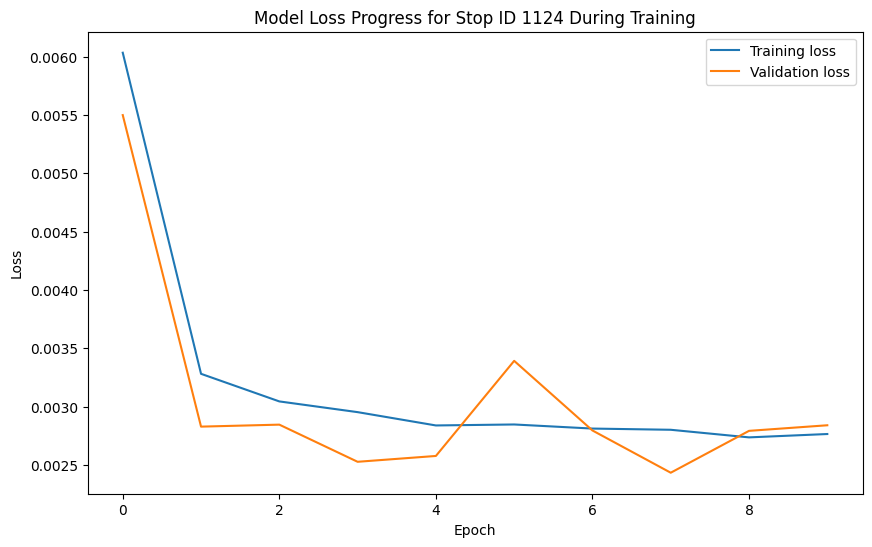

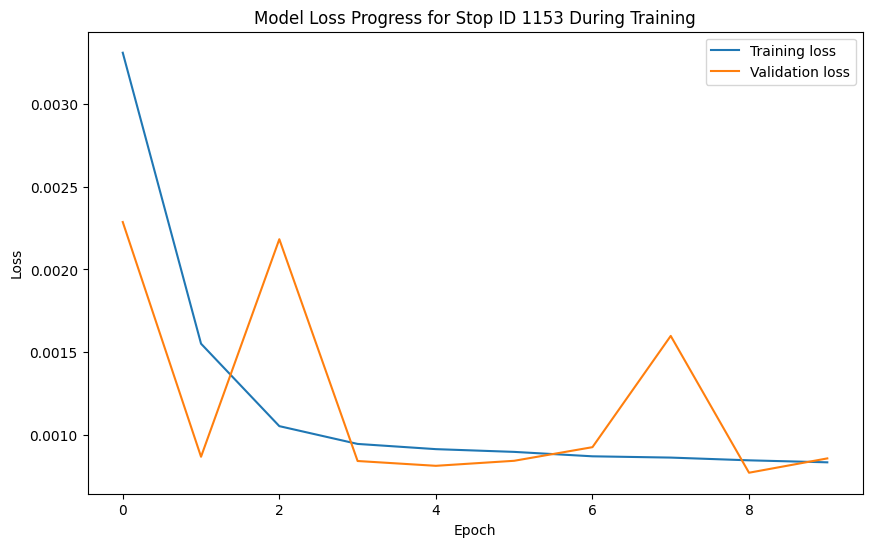

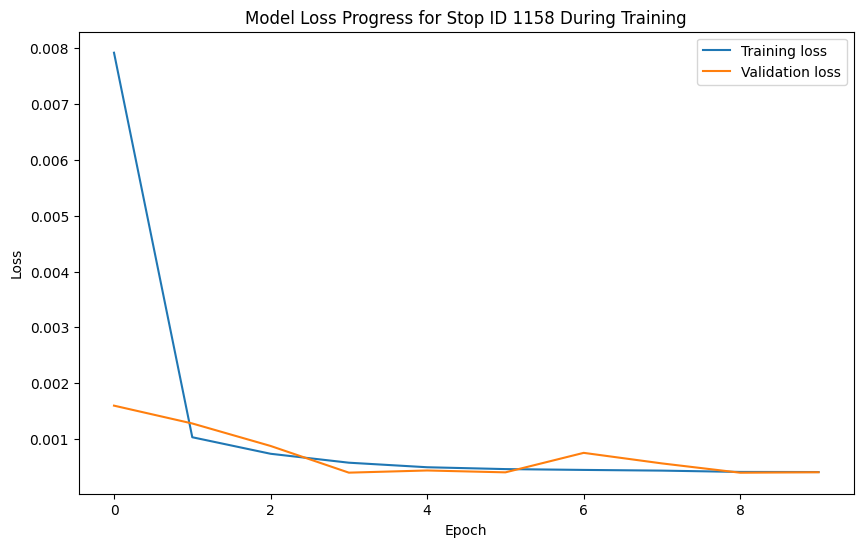

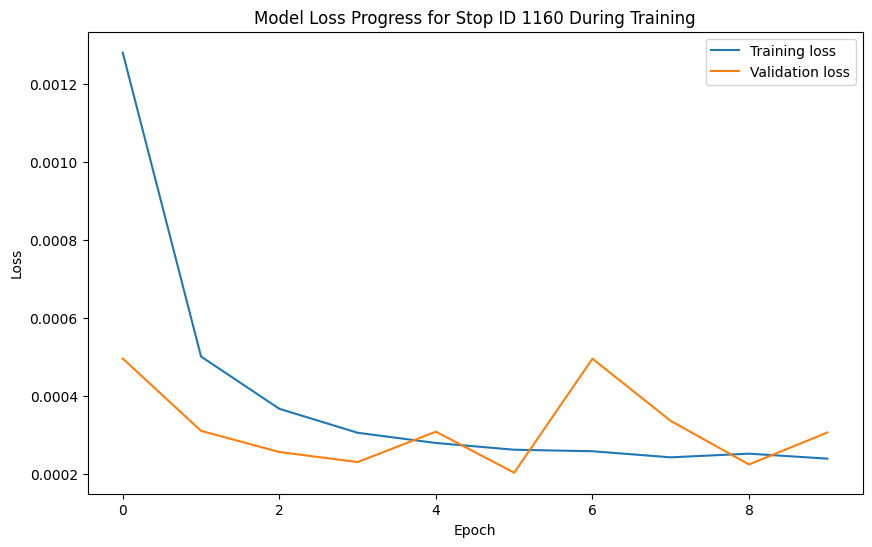

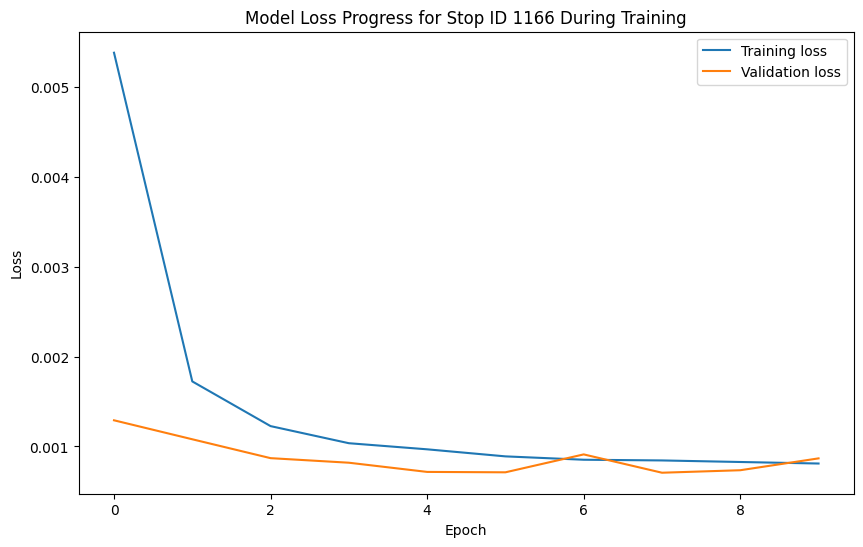

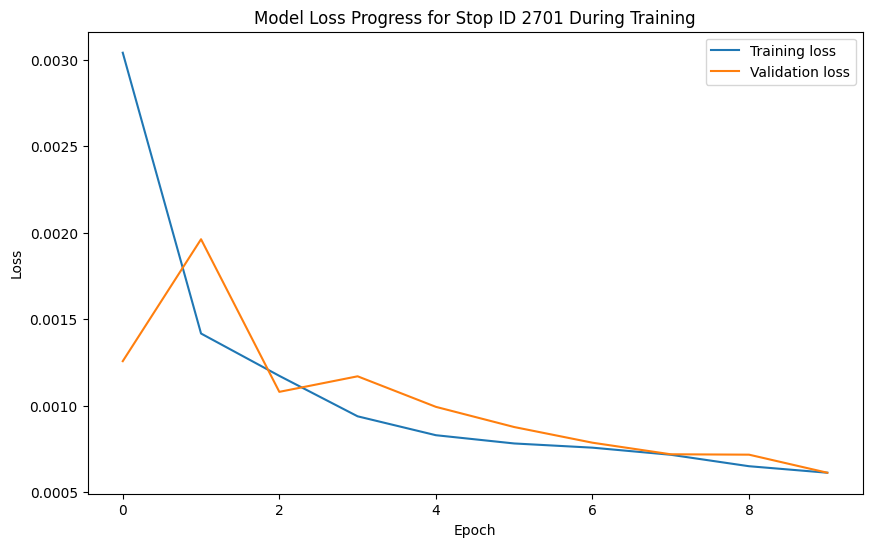

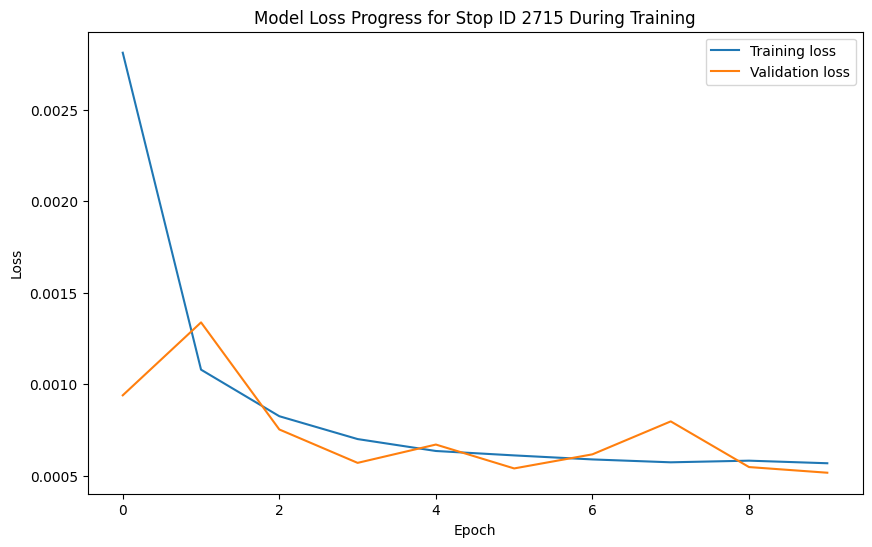

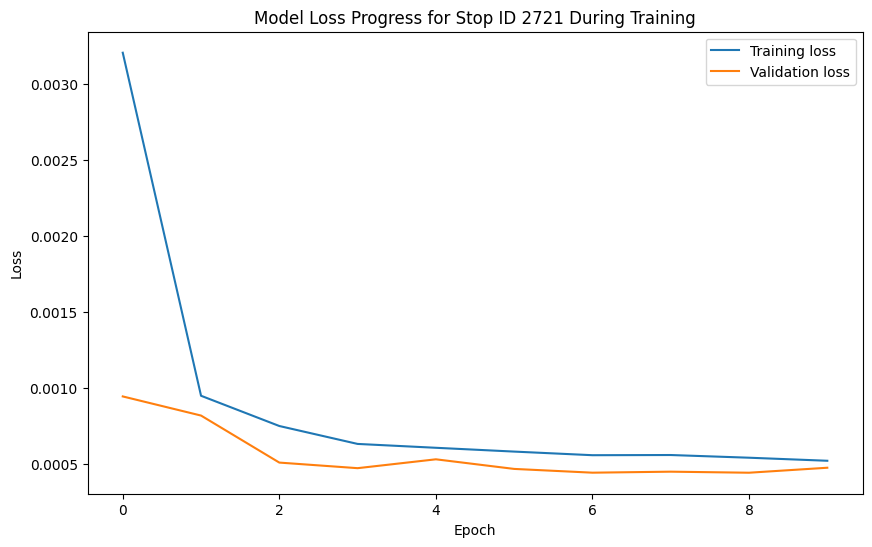

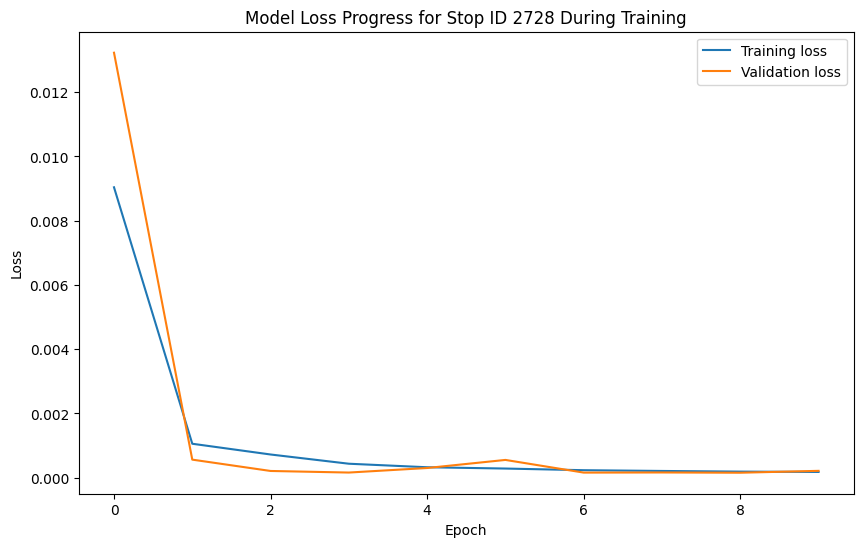

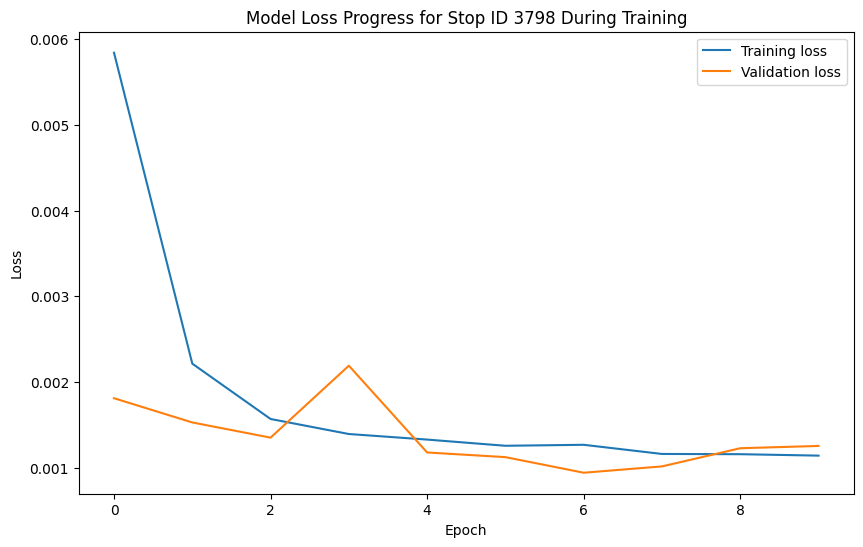

In [16]:
# 각 대여소별 모델 학습 과정 시각화
import matplotlib.pyplot as plt

for ID, history in history_dict.items():
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.title(f'Model Loss Progress for Stop ID {ID} During Training')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
